<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/preprocessing_and_decomposition/FourierTransform.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fourier Transform**

The Fourier Transform is a mathematical technique that transforms a function of time, x(t), to a function of frequency, X(ω). [1]

The Inverse Fourier Transform changes a function of frequency, X(ω); back to a function of time, x(t).

"The Fourier Transform takes a time-based pattern, measures every possible cycle, and returns the overall "cycle recipe" (the amplitude, offset, & rotation speed for every cycle that was found)." [3]

References:


1.   https://lpsa.swarthmore.edu/Fourier/Xforms/FXformIntro.html#def
2.   https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
3.   https://betterexplained.com/articles/an-interactive-guide-to-the-fourier-transform/
4.   https://ccrma.stanford.edu/~jos/log/Introduction_DFT.html
5.   https://towardsdatascience.com/fast-fourier-transform-937926e591cb
6.   https://www.gaussianwaves.com/2011/01/fft-and-spectral-leakage-2/





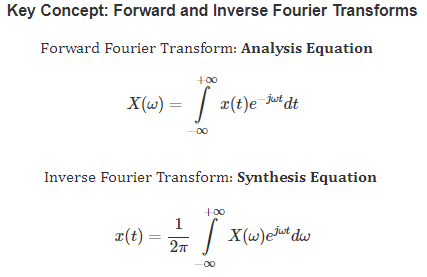

From Reference [1]

**Discrete Fourier Transform (DFT)**

The Discrete Fourier transform (DFT) is simply the discrete version




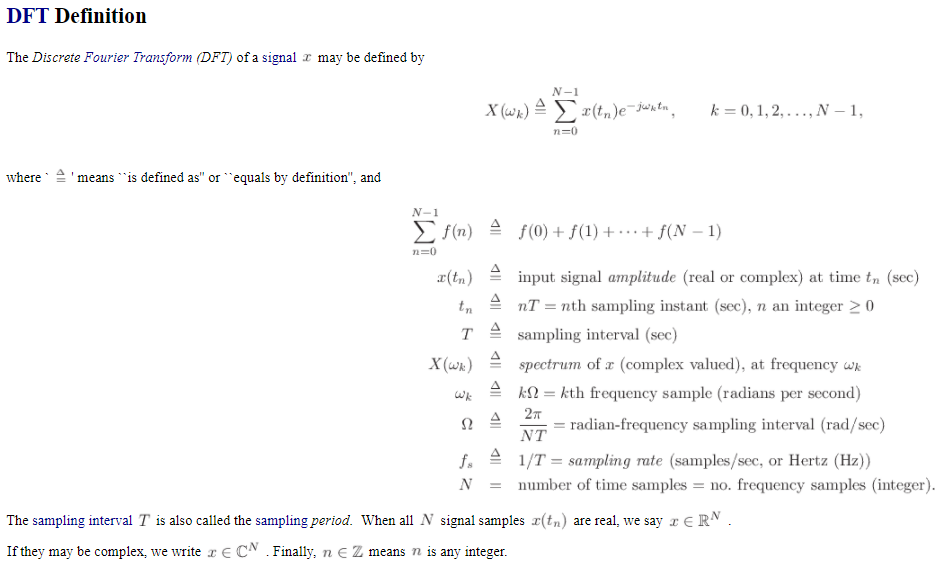

From Reference [4]

**Fast Fourier Transform (FFT)**

The FFT is an efficient *algorithm* for implementing the DFT. "As the name implies, the Fast Fourier Transform (FFT) is an algorithm that determines Discrete Fourier Transform of an input significantly faster than computing it directly. In computer science lingo, the FFT reduces the number of computations needed for a problem of size N from O(N^2) to O(NlogN)." [5]

The FFT divides the DFT into even and odd indexed sub-sequences.  Due to symmetry in theses sub-sequences, they can be computed concurrently.  Additionally, a divided and conquer methodology can be used on these sub-sequences to can further computational efficiency.  These smaller sub-sequences be computed even more efficiently by computing them as a single matrix-matrix product.

In [ ]:
# Installation

!pip install influxdb
!pip install pyFFTW

     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 2.6MB 6.5MB/s 


In [ ]:
#Standard DFT

import pyfftw
import numpy as np

def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)


In [ ]:
#Basic FFT

def FFT(x):
    """A recursive implementation of the 1D Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    
    if N % 2 > 0:
        raise ValueError("size of x must be a power of 2")
    elif N <= 32:  # this cutoff should be optimized
        return DFT_slow(x)
    else:
        X_even = FFT(x[::2])
        X_odd = FFT(x[1::2])
        factor = np.exp(-2j * np.pi * np.arange(N) / N)
        return np.concatenate([X_even + factor[:N // 2] * X_odd,
                               X_even + factor[N // 2:] * X_odd])

In [ ]:
#Vectorized FFT

def FFT_vectorized(x):
    """A vectorized, non-recursive version of the Cooley-Tukey FFT"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]

    if np.log2(N) % 1 > 0:
        raise ValueError("size of x must be a power of 2")

    # N_min here is equivalent to the stopping condition above,
    # and should be a power of 2
    N_min = min(N, 32)
    
    # Perform an O[N^2] DFT on all length-N_min sub-problems at once
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))

    # build-up each level of the recursive calculation all at once
    while X.shape[0] < N:
        X_even = X[:, :X.shape[1] // 2]
        X_odd = X[:, X.shape[1] // 2:]
        factor = np.exp(-1j * np.pi * np.arange(X.shape[0])
                        / X.shape[0])[:, None]
        X = np.vstack([X_even + factor * X_odd,
                       X_even - factor * X_odd])

    return X.ravel()

In [ ]:
# Verification that above algorithms produce the correct result

x = np.random.random(1024)

np.allclose(FFT(x), np.fft.fft(x))

True

In [ ]:
# Verification that above algorithms produce the correct result

np.allclose(FFT_vectorized(x), np.fft.fft(x))

True

In [ ]:
# Comparisions of Standard DFT to Basic FFT

%timeit DFT_slow(x)
%timeit FFT(x)
%timeit np.fft.fft(x)

10 loops, best of 5: 121 ms per loop
100 loops, best of 5: 7.93 ms per loop
The slowest run took 8.09 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 15.7 µs per loop


In [ ]:
# Comparisons of Basic FFT to Vectorized FFT

x2 = np.random.random(1024 * 16)

%timeit FFT(x2)
%timeit FFT_vectorized(x2)
%timeit np.fft.fft(x2)

10 loops, best of 5: 134 ms per loop
100 loops, best of 5: 4.3 ms per loop
1000 loops, best of 5: 284 µs per loop


/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


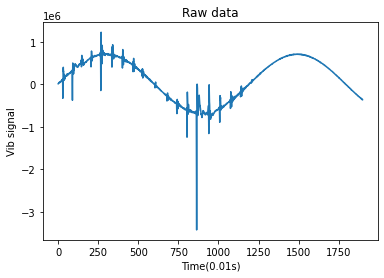

In [ ]:
# Example Data Preperation

import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp

from numpy.fft import rfft, irfft, rfftfreq
from scipy import fftpack
import pandas as pd

ip = "sensorweb.us" 
unit = "b8:27:eb:48:68:fa" # FloorB
stampIni = "2020-08-22T00:42:41.000Z" # UTC time = EST time + 4
stampEnd = "2020-08-22T00:43:00.000Z"
client = InfluxDBClient(ip, "8086", "sili", "sensorweb", "floorseis",   True)
# Check FloorB at http://3.136.84.223:3000/d/3HdIpxGMz/s-house-dashboard-raw-data-only?orgId=1&from=1594149493945&to=1594149503005

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit+'\')  and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\'   '
result = client.query(query)
points = list(result.get_points())
values =  map(operator.itemgetter('value'), points)
times  =  map(operator.itemgetter('time'),  points)
data = np.array(list(values))
if(len(data) == 0):
  print("No data in the chosen time range!")
  quit()
time        = np.arange(0, 10, 10/len(data));
data   = data + np.sin(time)*max(data)



plt.xlabel('Time(0.01s)')
plt.ylabel('Vib signal')
plt.title("Raw data")
plt.plot(data) # [mintime:maxtime-1])
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


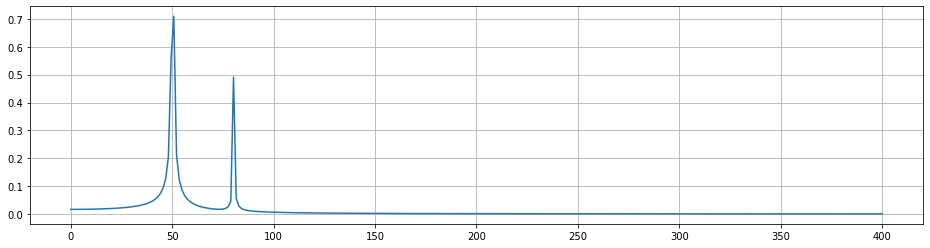

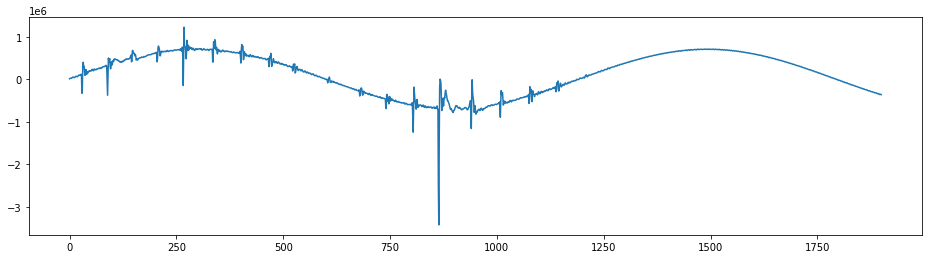

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


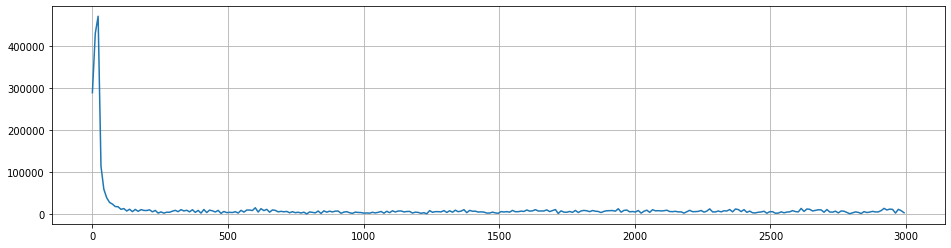

In [ ]:
# FFT time series example

from scipy import fft
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import signal
import numpy as np

# Number of sample points
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

# use seismic data
# y = data
# T = 1.0/100.0

# use electric-wave data
# y = data
# T = 1.0/60.0

yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
plt.figure(figsize=(16, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

y = data
fs = 20000
N = len(y)
x = np.linspace(0.0, N/fs, N)

plt.figure(figsize=(16, 4))
plt.plot(y)
plt.show()

maxf = 3000
minf = 0

yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0/fs), N//2)
pyf = 2.0/N * np.abs(yf[0:N//2])
l = len(xf)
plt.figure(figsize=(16, 4))

plt.plot(xf[int(minf*2*l/fs):int(maxf*2*l/fs)], pyf[int(minf*2*l/fs):int(maxf*2*l/fs)])
plt.grid()
plt.show()

# **Short-time Fourier Transform (STFT)**

author: Woody

The Short-time Fourier transform (STFT), is a Fourier-related transform used to determine the sinusoidal frequency and phase content of local sections of a signal as it changes over time. In practice, the procedure for computing STFTs is to divide a longer time signal into shorter segments of equal length and then compute the Fourier transform separately on each shorter segment. This reveals the Fourier spectrum on each shorter segment. One then usually plots the changing spectra as a function of time, known as a spectrogram or waterfall plot.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.


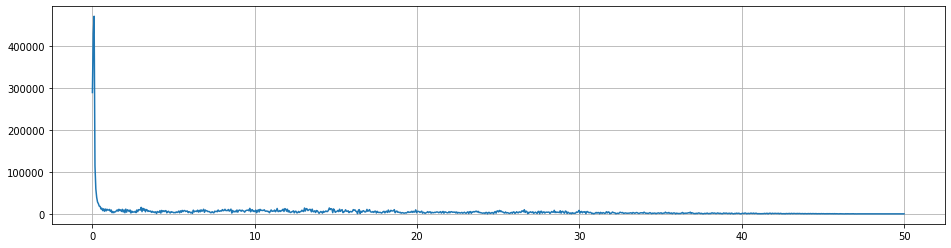

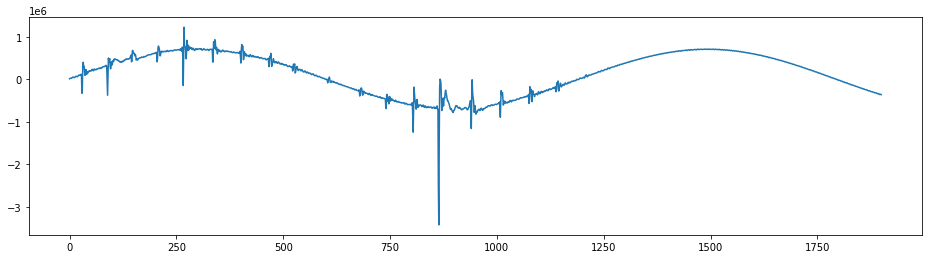

/usr/local/lib/python3.7/dist-packages/scipy/signal/spectral.py:1966: UserWarning: nperseg = 2000 is greater than input length  = 1900, using nperseg = 1900
  .format(nperseg, input_length))


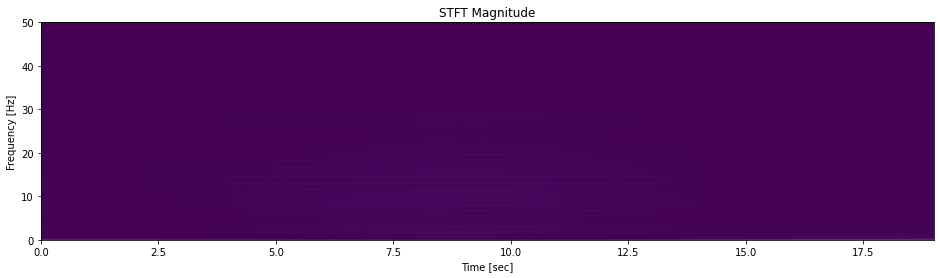

In [ ]:
# STFT Example

from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft


# example with synthetic data
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power),
                         size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

# # use seismic data
y = data
fs = 100
fmin = 0
fmax = 50
npseg = 2000

# use e-wave data
# y = data
# fs = 20000
# fmin = 0
# fmax = 400
# npseg = 2000



N = len(y)
x = np.linspace(0.0, N/fs, N)


yf = fft(y)
xf = np.linspace(0.0, 1.0/(2.0/fs), N//2)
spec = 2.0/N * np.abs(yf[0:N//2])
plt.figure(figsize=(16, 4))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()

x = y
#fs = 20000
slidingstep=200

plt.figure(figsize=(16, 4))
plt.plot(x)
plt.show()

f, t, Zxx = signal.stft(x, fs, nperseg=npseg, noverlap = npseg-slidingstep)
plt.figure(figsize=(16, 4))
plt.pcolormesh(t, f[int(fmin*npseg/fs):int(fmax*npseg/fs)+1], np.abs(Zxx[int(fmin*npseg/fs):int(fmax*npseg/fs)+1,:]), shading='gouraud')
#plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud')

plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
#print(f)

# **Pros & Cons of FFT**

**Pros:**

*   FFT is a very efficient way to compute the DFT of a vector
*   It is linear and sometimes it is useful to use its matrix representation when analyzing it or when doing some theoretical analysis.
*   It is a standard way to make frequency domain analysis of a time series data



**Cons:** 

*   Fourier transform does not work with nonstationary noise and signal with abrupt change
*   The resolution depends on the points per segmentation
*   Vulnerable to sprectral leakage caused by a mismatch between desired tone and chosen frequency resolution, time limiting an observation [6]